<a href="https://colab.research.google.com/github/XtremeMilan/Fake-News-Detection-System/blob/main/Fake_News_Detection_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Dropout, Dense, Embedding
from keras import Sequential
import re
import nltk
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Loading Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_train = pd.read_csv('/content/drive/MyDrive/Fake News Detection System/train.csv')

In [ ]:
data_train.head(3)

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1


In [ ]:
data_train['text'][0]

'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It By Darrell Lucus on October 30, 2016 Subscribe Jason Chaffetz on the stump in American Fork, Utah ( image courtesy Michael Jolley, available under a Creative Commons-BY license) \nWith apologies to Keith Olbermann, there is no doubt who the Worst Person in The World is this week–FBI Director James Comey. But according to a House Democratic aide, it looks like we also know who the second-worst person is as well. It turns out that when Comey sent his now-infamous letter announcing that the FBI was looking into emails that may be related to Hillary Clinton’s email server, the ranking Democrats on the relevant committees didn’t hear about it from Comey. They found out via a tweet from one of the Republican committee chairmen. \nAs we now know, Comey notified the Republican chairmen and Democratic ranking members of the House Intelligence, Judiciary, and Oversight committees that his agency was reviewing emai

In [ ]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


# Pre-Processing Data

## Removing Unwanted Columns

In [ ]:
data = data_train.drop(['id','title','author'],axis=1)

In [ ]:
data.columns

Index(['text', 'label'], dtype='object')

## Removing Null Values

In [ ]:
data.isnull().sum()

text     39
label     0
dtype: int64

In [ ]:
data = data.dropna(axis=0)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20761 entries, 0 to 20799
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    20761 non-null  object
 1   label   20761 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 486.6+ KB


## Pre-Processing 'text' Column

In [ ]:
# Lowercasing
data['news_text']=data['text'].str.lower()

In [ ]:
data['news_text']

0        house dem aide: we didn’t even see comey’s let...
1        ever get the feeling your life circles the rou...
2        why the truth might get you fired october 29, ...
3        videos 15 civilians killed in single us airstr...
4        print \nan iranian woman has been sentenced to...
                               ...                        
20795    rapper t. i. unloaded on black celebrities who...
20796    when the green bay packers lost to the washing...
20797    the macy’s of today grew from the union of sev...
20798    nato, russia to hold parallel exercises in bal...
20799      david swanson is an author, activist, journa...
Name: news_text, Length: 20761, dtype: object

In [ ]:
# Removing Unwanted Characters
data['news_text'] = data['news_text'].str.replace('[^A-Za-z0-9\s]', '')
data['news_text'] = data['news_text'].str.replace('\n', '')
data['news_text'] = data['news_text'].str.replace('\s+', ' ')

In [ ]:
data['news_text']

0        house dem aide: we didn’t even see comey’s let...
1        ever get the feeling your life circles the rou...
2        why the truth might get you fired october 29, ...
3        videos 15 civilians killed in single us airstr...
4        print an iranian woman has been sentenced to s...
                               ...                        
20795    rapper t. i. unloaded on black celebrities who...
20796    when the green bay packers lost to the washing...
20797    the macy’s of today grew from the union of sev...
20798    nato, russia to hold parallel exercises in bal...
20799      david swanson is an author, activist, journa...
Name: news_text, Length: 20761, dtype: object

## Using StopWords

In [ ]:
nltk.download('stopwords')
words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
data['news_text'] = data['news_text'].apply(lambda x: " ".join([word for word in x.split() if word not in words]))
data.head()

,text,label,news_text
0,House Dem Aide: We Didn’t Even See Comey’s Let...,1,house dem aide: didn’t even see comey’s letter...
1,Ever get the feeling your life circles the rou...,0,ever get feeling life circles roundabout rathe...
2,"Why the Truth Might Get You Fired October 29, ...",1,"truth might get fired october 29, 2016 tension..."
3,Videos 15 Civilians Killed In Single US Airstr...,1,videos 15 civilians killed single us airstrike...
4,Print \nAn Iranian woman has been sentenced to...,1,print iranian woman sentenced six years prison...


# Tokenizing Data

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['news_text'])
word_index = tokenizer.word_index
vocab_size = len(word_index)

In [ ]:
print(vocab_size)

239494


# Padding the sequences

In [ ]:
sequences = tokenizer.texts_to_sequences(data['news_text'])
padded_sequence = pad_sequences(sequences, maxlen=500, padding='post', truncating='post')

# Embedding Matrix
## Using pre-trained GloVe Model

In [ ]:
embedding_index = {}
with open('/content/drive/MyDrive/Fake News Detection System/glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

In [ ]:
embedding_matrix = np.zeros((vocab_size+1, 100))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix[2]

array([-0.13128   , -0.45199999,  0.043399  , -0.99798   , -0.21053   ,
       -0.95867997, -0.24608999,  0.48413   ,  0.18178   ,  0.47499999,
       -0.22305   ,  0.30063999,  0.43496001, -0.36050001,  0.20245001,
       -0.52594   , -0.34707999,  0.0075873 , -1.04970002,  0.18673   ,
        0.57369   ,  0.43814   ,  0.098659  ,  0.38769999, -0.22579999,
        0.41911   ,  0.043602  , -0.73519999, -0.53583002,  0.19276001,
       -0.21961001,  0.42515001, -0.19081999,  0.47187001,  0.18826   ,
        0.13357   ,  0.41839001,  1.31379998,  0.35677999, -0.32172   ,
       -1.22570002, -0.26635   ,  0.36715999, -0.27586001, -0.53245997,
        0.16786   , -0.11253   , -0.99958998, -0.60706002, -0.89270997,
        0.65156001, -0.88783997,  0.049233  ,  0.67110997, -0.27553001,
       -2.40050006, -0.36989   ,  0.29135999,  1.34979999,  1.73529994,
        0.27000001,  0.021299  ,  0.14421999,  0.023784  ,  0.33643001,
       -0.35475999,  1.09210002,  1.48450005,  0.49430001,  0.15

In [ ]:
padded_sequence[2]

array([  648,   121,    33,  1382,   272,  1652,    60,  4766,   358,
        2096,    59, 16073,   249,  2632,  9497,  8129,   614,  4585,
         217,  3820,    84,   581,    62,  1782,  6853, 12580,  6853,
       12580,   121,  2215,   159,   128,  4570,  1407,    44,   524,
        2787,  6012,   121,  2832,   553,  1384,   510,  2755,    28,
          22,  4372,   595,  3562,    49,   276,  2107,  2570,   661,
         961,   811,  6280,  2548,   581,     6,   788,    70,  1250,
         837,  1047,  5403,  6335,  5210,  8271,  2665,   411,   605,
        4188,   605,   960,  1990,   197,   491,   283,   842,  1247,
         864,    90,  1648,   349, 11247,  9278,   456,   448,    12,
         661,   961,   811,   884,    12,  6804, 10639,  1451,  3379,
         140,  1142,  1793,   212,   661, 20371,    11,  1077,   236,
         607,  5908,  2360,   556,    77,    51,    47,  1183,  3759,
        9913,  2677,   581,   180,  3859,   411,   113,    12,   811,
         353,  3576,

# Using Train_Test_Split

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(padded_sequence, data['label'], test_size=0.20, random_state=42, stratify=data['label'])

# Building LSTM Model

In [ ]:
model = Sequential([
     Embedding(vocab_size+1, 100, weights=[embedding_matrix], trainable=False),
     LSTM(128, return_sequences=True),
     Dropout(0.2),
     LSTM(128),
     Dropout(0.2),
     Dense(512),
     Dropout(0.2),
     Dense(256),
     Dense(1, activation='sigmoid')
 ])

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         23949500  
                                                                 
 lstm (LSTM)                 (None, None, 128)         117248    
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 512)               66048     
                                                                 
 dropout_2 (Dropout)         (None, 512)               0

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Define callbacks
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001, verbose=1)

# Fit the model with callbacks
history = model.fit(X_train, Y_train, epochs=15, batch_size=256, validation_data=(X_test, Y_test),
                    callbacks=[checkpoint, early_stopping, reduce_lr])


Epoch 1/15
65/65 [==============================] - ETA: 0s - loss: 0.6147 - accuracy: 0.6670
Epoch 1: val_accuracy improved from -inf to 0.61883, saving model to best_model.h5
65/65 [==============================] - 15s 123ms/step - loss: 0.6147 - accuracy: 0.6670 - val_loss: 0.6692 - val_accuracy: 0.6188 - lr: 0.0010
Epoch 2/15
65/65 [==============================] - ETA: 0s - loss: 0.5962 - accuracy: 0.6762
Epoch 2: val_accuracy improved from 0.61883 to 0.70094, saving model to best_model.h5
65/65 [==============================] - 7s 111ms/step - loss: 0.5962 - accuracy: 0.6762 - val_loss: 0.5370 - val_accuracy: 0.7009 - lr: 0.0010
Epoch 3/15
65/65 [==============================] - ETA: 0s - loss: 0.5473 - accuracy: 0.7295
Epoch 3: val_accuracy improved from 0.70094 to 0.78594, saving model to best_model.h5
65/65 [==============================] - 7s 110ms/step - loss: 0.5473 - accuracy: 0.7295 - val_loss: 0.4876 - val_accuracy: 0.7859 - lr: 0.0010
Epoch 4/15
65/65 [============

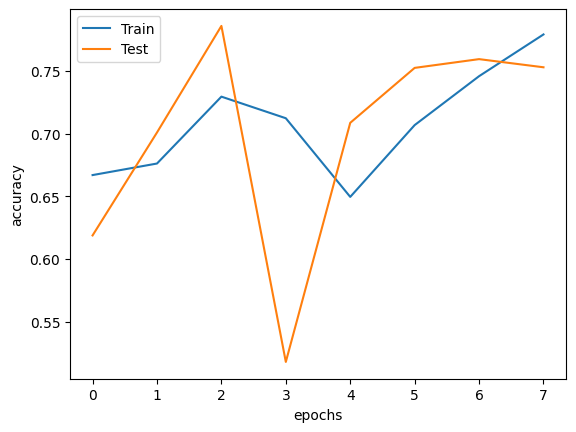

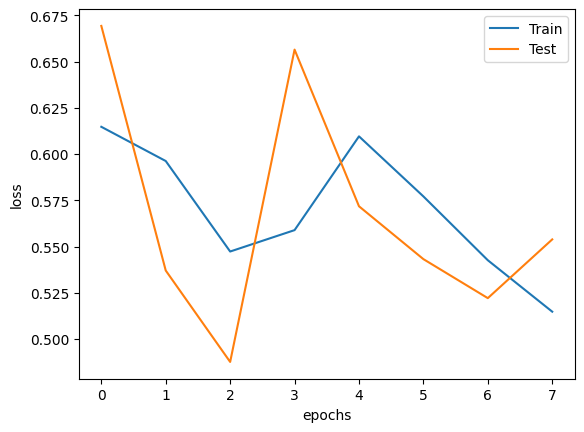

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['Train', 'Test'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['Train', 'Test'])
plt.show()

In [ ]:
# Install Streamlit
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.0 MB/s eta 0:00:00


In [ ]:
%%writefile /content/app.py

import numpy as np
import streamlit as st
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


model_path = "/content/best_model.h5"  # Update with the path to your saved model
model = load_model(model_path)

# Preprocess function
def preprocess_text(input_text):
    # Convert text to lowercase
    processed_text = input_text.lower()

    # Remove non-alphanumeric characters
    processed_text = re.sub('[^A-Za-z0-9\s]', '', processed_text)

    # Remove newline characters
    processed_text = processed_text.replace('\n', '')

    # Remove extra whitespaces
    processed_text = re.sub('\s+', ' ', processed_text)

    # Remove stopwords
    words = processed_text.split()
    stop_words = set(stopwords.words('english'))
    processed_text = " ".join([word for word in words if word not in stop_words])

    return processed_text

def tokenize_and_pad(text):
    # Tokenize text
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts([text])
    sequences = tokenizer.texts_to_sequences([text])

    # Pad sequences
    padded_sequence = pad_sequences(sequences, maxlen=500, padding='post', truncating='post')

    return padded_sequence

# Define the Streamlit frontend code
def main():
    st.title("Fake News Detection System")
    st.write("Welcome to the Fake News Detection System!")
    st.write("Enter a news article below to check if it's fake or genuine.")

    # Input field for entering news article text
    news_text = st.text_area("Enter the news article here:", "")

    # Button to trigger the model prediction
    if st.button("Check News"):
        # Preprocess the input text
        processed_text = preprocess_text(news_text)
        padded_text = tokenize_and_pad(processed_text)

        # Tokenize and pad the processed text

        # Make a prediction using the loaded model
        prediction = model.predict(padded_text)
        prediction_label = "Genuine" if prediction > 0.5 else "Fake"
        prediction_probability = f"{prediction[0][0]:.2f}"  # Format probability to two decimal places

        # Display the prediction result to the user
        st.write(f"The news article is: {prediction_label}")
        st.write(f"Prediction probability: {prediction_probability}")

# Run the Streamlit app
if __name__ == "__main__":
    main()

Writing /content/app.py


In [ ]:
!wget -q -O - ipv4.icanhazip.com

34.91.151.203


In [ ]:
!streamlit run /content/app.py & npx localtunnel --port 8501



npx: installed 22 in 3.521s
your url is: https://fuzzy-groups-attack.loca.lt

  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://34.91.151.203:8501

